In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
file = pd.read_csv('model_data.csv')

In [3]:
file = file.fillna(0)

### Preprocessing
- Minor changes needed. 
- Convert 'created_at' to datetime
- Convert 'collection_name' to ints

In [4]:
# Manually convert collection_name into nums
collections = {}
count = 1
for col in file['collection_name'].unique():
    collections[col] = count
    count += 1
    
file['collection_name'] = file['collection_name'].apply(lambda x: collections[x])

In [5]:
# Convert to datetime
file['created_at'] = file['created_at'].apply(lambda x: pd.to_datetime(x))
file = file.set_index('created_at')

In [6]:
file.dtypes

final_vader_score         float64
prices_scaled             float64
previous_day_sentiment    float64
trends                    float64
trends_previous_day       float64
trends_two_days_prior     float64
num_tweets                  int64
collection_name             int64
dtype: object

# Let's do some MODELING

## Create Train and Test data

In [8]:
init_df = file[file['collection_name']==1].copy()

In [9]:
(X, y) = (np.array(init_df.drop(columns=['prices_scaled'])), np.array(init_df['prices_scaled']))

In [10]:
# from sklearn.model_selection import train_test_split

# def split_data(data, test_size):
#     (X_temp, y_temp) = (np.array(data.drop(columns=['prices_scaled'])), np.array(data['prices_scaled']))
#     X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_temp, y_temp, test_size=0.2, random_state=699)
#     return(X_train_temp, X_test_temp, y_train_temp, y_test_temp)

# Source: https://medium.com/keita-starts-data-science/time-series-split-with-scikit-learn-74f5be38489e
def split_data(data, test_size):
    X = data.drop(columns=['prices_scaled'])
    y = data['prices_scaled']
    X_train = X[:int(data.shape[0]*(test_size/100))]
    X_test = X[int(data.shape[0]*(test_size/100)):]
    y_train = y[:int(data.shape[0]*(test_size/100))]
    y_test = y[int(data.shape[0]*(test_size/100)):]
    return(X_train, X_test, y_train, y_test)

In [11]:
def create_test_train(df, test_size):
    collection_names = df['collection_name'].unique()
    main_data = split_data(df[df['collection_name']==collection_names[0]], test_size)
    X_train = main_data[0]
    X_test = main_data[1]
    y_train = main_data[2]
    y_test = main_data[3]
    
    for collection_name in collection_names[1:]:
        try:
            new_data = split_data(df[df['collection_name']==collection_name], test_size)
            X_train = X_train.append(new_data[0])
            X_test = X_test.append(new_data[1])
            y_train = y_train.append(new_data[2])
            y_test = y_test.append(new_data[3])
        except ValueError:
            print("ERROR:")
            for item in collections.items():
                if item[1]==collection_name:
                    print(item)
            pass
#     X_train = np.array(X_train)
#     X_test = np.array(X_test)
#     y_train = np.array(y_train)
#     y_test = np.array(y_test)
    return(X_train, X_test, y_train, y_test)

In [12]:
test = create_test_train(file, 80)

In [13]:
X_train = test[0].reset_index(drop=True)
X_test = test[1].reset_index(drop=True)
y_train = test[2].reset_index(drop=True)
y_test = test[3].reset_index(drop=True)

In [14]:
# Creating a 20% sample to speed up initial model generation
X_train_sample = X_train.sample(n=int((X_train.shape[0])*.2), random_state=699)
y_train_sample = y_train.iloc[X_train_sample.index]

## ARIMA

Source: https://builtin.com/data-science/time-series-forecasting-python

In [108]:
from sklearn.metrics import mean_squared_error

In [109]:
import warnings
warnings.filterwarnings("ignore")

In [110]:
# !pip install pmdarima
from pmdarima.arima import auto_arima

In [111]:
# Source: https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd
arima_model = auto_arima(y_train, start_p=0, d=1, start_q=0,
                        max_p=5, max_d=5, max_q=5, start_P=0,
                        D=1, start_Q=0, max_P=5, max_D=5,
                        max_Q=5, m=12, seasonal=False, error_action='warn',
                         trace=True, suppress_warnings=True, stepwise=True,
                        random_state=699, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9157.901, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8936.400, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8736.483, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9155.907, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8570.003, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=8518.860, Time=1.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.07 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=4.08 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=8472.800, Time=4.21 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=4.73 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=4.84 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=4.21 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.57 sec
 ARIMA(

In [252]:
arima_preds = arima_model.predict(y_test.shape[0])

arma_rmse = np.sqrt(mean_squared_error(y_test, arima_preds))
print("RMSE: ",arma_rmse)

RMSE:  0.9946951636068639


Conclusion: ARIMA is not bad!

## Linear Regression

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
# Import
from sklearn.linear_model import LinearRegression

In [23]:
# Generate base model
lin_model = LinearRegression().fit(X_train, y_train)

Use GridSearchCV to find the best hyper-parameters

In [24]:
parameter_options = {'fit_intercept':['True', 'False'],
                     'copy_X':['True', 'False']}

In [25]:
lin_grid = GridSearchCV(lin_model, parameter_options, cv = 3)

In [26]:
lin_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LinearRegression(),
             param_grid={'copy_X': ['True', 'False'],
                         'fit_intercept': ['True', 'False']})

In [27]:
# print best parameters
print(lin_grid.best_params_)

{'copy_X': 'True', 'fit_intercept': 'True'}


In [28]:
# Model generation with the best parameters
lin_model = LinearRegression(copy_X=True, fit_intercept=True)
lin_model.fit(X_train, y_train)

LinearRegression()

In [29]:
# Prediction
y_test_pred_lin = lin_model.predict(X_test)

### SVM

In [114]:
# Import
from sklearn.svm import LinearSVR

In [115]:
# Generate base model
svm_model = LinearSVR().fit(X_train_sample, y_train_sample)

GridSearchCV to find the best parameters

In [116]:
parameter_options = {'epsilon':[0.0, 0.1, 0.25, 0.5],
                     'loss':['epsilon_insensitive', 'squared_epsilon_insensitive'],
                     'fit_intercept':['True', 'False']}

In [117]:
svm_grid = GridSearchCV(svm_model, parameter_options, cv=5)

In [118]:
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearSVR(),
             param_grid={'epsilon': [0.0, 0.1, 0.25, 0.5],
                         'fit_intercept': ['True', 'False'],
                         'loss': ['epsilon_insensitive',
                                  'squared_epsilon_insensitive']})

In [119]:
# print best parameters
print(svm_grid.best_params_)

{'epsilon': 0.5, 'fit_intercept': 'False', 'loss': 'squared_epsilon_insensitive'}


Applying the best parameters to the new SVM

In [120]:
# Best model for SVM
svm_model = LinearSVR(epsilon=0.5, fit_intercept=False, loss='squared_epsilon_insensitive', random_state=699)
svm_model.fit(X_train_sample, y_train_sample)

LinearSVR(epsilon=0.5, fit_intercept=False, loss='squared_epsilon_insensitive',
          random_state=699)

In [121]:
y_test_pred_svm = svm_model.predict(X_test)

### RandomForest Regressor

In [122]:
# Import
from sklearn.ensemble import RandomForestRegressor

In [123]:
# Generate base model
rf_model = RandomForestRegressor(random_state=699)

GridSearchCV

In [131]:
parameter_options = {'n_estimators':[10, 50, 100, 200],
                     'min_samples_split':[0.5, 1, 1.5, 2, 3],
                     'min_samples_leaf':[0.1, 0.5, 1, 2],
                    'max_depth':[5, 10, 25, 50, 100],
                    }

In [132]:
rf_grid = GridSearchCV(rf_model, parameter_options, cv=5)

In [133]:
rf_grid.fit(X_train_sample, X_train_sample)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=699),
             param_grid={'max_depth': [5, 10, 25, 50, 100],
                         'min_samples_leaf': [0.1, 0.5, 1, 2],
                         'min_samples_split': [0.5, 1, 1.5, 2, 3],
                         'n_estimators': [10, 50, 100, 200]})

In [134]:
# print best parameters
print(rf_grid.best_params_)

{'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [135]:
# Using best paramters to create the model
rf_model = RandomForestRegressor(max_depth=25, min_samples_leaf=1, min_samples_split=2,
                                 n_estimators=50,random_state=699)

In [136]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, n_estimators=50, random_state=699)

In [137]:
y_test_pred_rf = rf_model.predict(X_test)

### SGDRegressor

In [138]:
# Import
from sklearn.linear_model import SGDRegressor

In [139]:
# Generate base model
sgdr_model = SGDRegressor(random_state=699)

GridSearchCV

In [140]:
parameters = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.99, 1],
             'l1_ratio':[0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.8, 0.9, 0.99, 1],
             'penalty':['l1', 'l2', 'elasticnet'],
             'epsilon':[0.001, 0.01, 0.1, 0, -0.1],
             'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive']}

In [141]:
sgd_grid = GridSearchCV(sgdr_model, parameters)

In [142]:
sgd_grid.fit(X_train, y_train)

GridSearchCV(estimator=SGDRegressor(random_state=699),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.99,
                                   1],
                         'epsilon': [0.001, 0.01, 0.1, 0, -0.1],
                         'l1_ratio': [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75,
                                      0.8, 0.9, 0.99, 1],
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'penalty': ['l1', 'l2', 'elasticnet']})

In [143]:
# print best parameters
print(sgd_grid.best_params_)

{'alpha': 1, 'epsilon': 0.001, 'l1_ratio': 0.8, 'learning_rate': 'adaptive', 'penalty': 'elasticnet'}


In [144]:
# Implement the best hyper-parameters
sgdr_model = SGDRegressor(random_state=699, alpha=1, epsilon=0.001, l1_ratio=0.8, learning_rate='adaptive',
                          penalty='elasticnet')
sgdr_model.fit(X_train, y_train)

SGDRegressor(alpha=1, epsilon=0.001, l1_ratio=0.8, learning_rate='adaptive',
             penalty='elasticnet', random_state=699)

In [145]:
y_test_pred_sgdr = sgdr_model.predict(X_test)

## KNN

Source: https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/

In [146]:
#import required packages
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [147]:
rmse_val = [] #to store rmse values for different k
ideal_k = 1
K = 1
knn_model = neighbors.KNeighborsRegressor(n_neighbors = K)
knn_model.fit(X_train, y_train)
pred=knn_model.predict(X_test) 
min_rmse = sqrt(mean_squared_error(y_test,pred))


for K in range(2, 20):
    knn_model = neighbors.KNeighborsRegressor(n_neighbors = K)
    knn_model.fit(X_train, y_train)
    pred=knn_model.predict(X_test)
    error = sqrt(mean_squared_error(y_test,pred))
    if error < min_rmse:
        min_rmse = error
        ideal_k = K   

In [148]:
print(ideal_k, min_rmse)

19 0.8731537005321648


In [149]:
#predicting on the test set and creating submission file

knn_model = neighbors.KNeighborsRegressor(n_neighbors = ideal_k)

knn_model.fit(X_train, y_train)  #fit the model
knn_y_pred=knn_model.predict(X_test) #make prediction on test set
knn_rmse = sqrt(mean_squared_error(y_test,pred))

# submission.to_csv('submit_file.csv',index=False)

## XGBoost

In [153]:
# pip install xgboost

In [154]:
import xgboost as xgb

In [155]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [156]:
xgb_preds = xgb_model.predict(X_test)

## MLP
Source: https://www.kaggle.com/code/dimitreoliveira/deep-learning-for-time-series-forecasting/notebook

In [162]:
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

In [164]:
epochs = 40
batch = 256
lr = 0.0003
adam = keras.optimizers.Adam(lr)

In [165]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)


In [166]:
mlp = model_mlp.fit(X_train.values, y_train, validation_data=(X_test.values, y_test), epochs=epochs, verbose=2)

Epoch 1/40
83/83 - 1s - loss: 99015.5625 - val_loss: 14063.4248 - 1s/epoch - 14ms/step
Epoch 2/40
83/83 - 0s - loss: 38633.1836 - val_loss: 7186.7822 - 99ms/epoch - 1ms/step
Epoch 3/40
83/83 - 0s - loss: 14339.7266 - val_loss: 1760.3177 - 92ms/epoch - 1ms/step
Epoch 4/40
83/83 - 0s - loss: 4928.2661 - val_loss: 861.6632 - 97ms/epoch - 1ms/step
Epoch 5/40
83/83 - 0s - loss: 1270.1305 - val_loss: 978.2702 - 91ms/epoch - 1ms/step
Epoch 6/40
83/83 - 0s - loss: 316.5521 - val_loss: 759.8698 - 105ms/epoch - 1ms/step
Epoch 7/40
83/83 - 0s - loss: 282.8712 - val_loss: 719.3157 - 99ms/epoch - 1ms/step
Epoch 8/40
83/83 - 0s - loss: 242.8035 - val_loss: 680.4196 - 97ms/epoch - 1ms/step
Epoch 9/40
83/83 - 0s - loss: 220.9642 - val_loss: 644.3497 - 100ms/epoch - 1ms/step
Epoch 10/40
83/83 - 0s - loss: 178.4832 - val_loss: 610.1302 - 98ms/epoch - 1ms/step
Epoch 11/40
83/83 - 0s - loss: 164.3673 - val_loss: 594.2090 - 100ms/epoch - 1ms/step
Epoch 12/40
83/83 - 0s - loss: 123.0013 - val_loss: 556.4749

In [179]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_test.values)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_test, mlp_valid_pred)))

Train rmse: 11.703293009783431
Validation rmse: 18.971673550860245


## CNN
Source: https://www.kaggle.com/code/dimitreoliveira/deep-learning-for-time-series-forecasting/notebook

In [170]:
from keras.layers.convolutional import Conv1D, MaxPooling1D

In [171]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

In [172]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)


In [174]:
cnn = model_cnn.fit(X_train_series, y_train, validation_data=(X_test_series, y_test), epochs=epochs, verbose=2)

Epoch 1/40
83/83 - 1s - loss: 138169.4219 - val_loss: 13499.4238 - 776ms/epoch - 9ms/step
Epoch 2/40
83/83 - 0s - loss: 47332.4609 - val_loss: 15120.5967 - 120ms/epoch - 1ms/step
Epoch 3/40
83/83 - 0s - loss: 1358.6268 - val_loss: 733.9719 - 126ms/epoch - 2ms/step
Epoch 4/40
83/83 - 0s - loss: 1578.5469 - val_loss: 4147.3247 - 116ms/epoch - 1ms/step
Epoch 5/40
83/83 - 0s - loss: 1303.9462 - val_loss: 642.9113 - 121ms/epoch - 1ms/step
Epoch 6/40
83/83 - 0s - loss: 1330.2444 - val_loss: 2941.3616 - 119ms/epoch - 1ms/step
Epoch 7/40
83/83 - 0s - loss: 1148.0604 - val_loss: 533.9023 - 121ms/epoch - 1ms/step
Epoch 8/40
83/83 - 0s - loss: 1038.7222 - val_loss: 446.2885 - 120ms/epoch - 1ms/step
Epoch 9/40
83/83 - 0s - loss: 991.2563 - val_loss: 152.7168 - 121ms/epoch - 1ms/step
Epoch 10/40
83/83 - 0s - loss: 311.3253 - val_loss: 776.3647 - 119ms/epoch - 1ms/step
Epoch 11/40
83/83 - 0s - loss: 948.2783 - val_loss: 567.3169 - 121ms/epoch - 1ms/step
Epoch 12/40
83/83 - 0s - loss: 3061.3730 - val

In [178]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_test_series)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_test, cnn_valid_pred)))

Train rmse: 81.17915884309974
Validation rmse: 37.19983335714089


## LSTM
Source: https://www.kaggle.com/code/dimitreoliveira/deep-learning-for-time-series-forecasting/notebook

In [175]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)

In [176]:
lstm = model_lstm.fit(X_train_series, y_train, validation_data=(X_test_series, y_test), epochs=epochs, verbose=2)

Epoch 1/40
83/83 - 1s - loss: 603.5184 - val_loss: 1061.0194 - 1s/epoch - 16ms/step
Epoch 2/40
83/83 - 0s - loss: 255.3672 - val_loss: 28.0798 - 310ms/epoch - 4ms/step
Epoch 3/40
83/83 - 0s - loss: 74.2767 - val_loss: 10.0006 - 271ms/epoch - 3ms/step
Epoch 4/40
83/83 - 0s - loss: 84.0127 - val_loss: 10.6552 - 266ms/epoch - 3ms/step
Epoch 5/40
83/83 - 0s - loss: 541.0098 - val_loss: 7.1137 - 302ms/epoch - 4ms/step
Epoch 6/40
83/83 - 0s - loss: 7.9078 - val_loss: 8.8533 - 275ms/epoch - 3ms/step
Epoch 7/40
83/83 - 0s - loss: 4.9430 - val_loss: 4.4840 - 268ms/epoch - 3ms/step
Epoch 8/40
83/83 - 0s - loss: 13.3523 - val_loss: 2.9583 - 269ms/epoch - 3ms/step
Epoch 9/40
83/83 - 0s - loss: 59.2596 - val_loss: 3.4202 - 304ms/epoch - 4ms/step
Epoch 10/40
83/83 - 0s - loss: 30.7511 - val_loss: 5.6408 - 310ms/epoch - 4ms/step
Epoch 11/40
83/83 - 0s - loss: 2.3903 - val_loss: 2.1487 - 279ms/epoch - 3ms/step
Epoch 12/40
83/83 - 0s - loss: 1.9805 - val_loss: 2.6806 - 303ms/epoch - 4ms/step
Epoch 13/4

In [180]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_test_series)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_test, lstm_valid_pred)))

Train rmse: 1.264484360239188
Validation rmse: 37.19983335714089


## Model Evaluation and Comparison

In [181]:
from sklearn import metrics

List of models:
- ARMAmodel, 
- lin_model, 
- svm_model, 
- rf_model,
- sgdr_model, 
- knn_model

In [208]:
# Outputting all the results
print('--- ARMA --- ')
print('Mean Absolute Error (MAE): ' + str(metrics.mean_absolute_error(y_test, arima_preds)))
# print('Mean Squared Error (MSE): ' + str(metrics.mean_squared_error(y_test, y_pred_out)))
print('Root MSE (rMSE): ' + str(np.sqrt(metrics.mean_squared_error(y_test, arima_preds))))
print('\n')

print('--- Linear Regression --- ')
print('Mean Absolute Error (MAE): ' + str(metrics.mean_absolute_error(y_test, y_test_pred_lin)))
# print('Mean Squared Error (MSE): ' + str(metrics.mean_squared_error(y_test, y_test_pred_lin)))
print('Root MSE (rMSE): ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_lin))))
print('CV mean score:', cross_val_score(lin_model, X, y, cv=10).mean())
print('\n')

print('--- SVM ---')
print('Mean Absolute Error (MAE): ' + str(metrics.mean_absolute_error(y_test, y_test_pred_svm)))
# print('Mean Squared Error (MSE): ' + str(metrics.mean_squared_error(y_test, y_test_pred_svm)))
print('Root MSE (rMSE): ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_svm))))
print('CV mean score:', cross_val_score(svm_model, X, y, cv=10).mean())
print('\n')

print('--- Random Forest Regression --- ')
print('Mean Absolute Error (MAE): ' + str(metrics.mean_absolute_error(y_test, y_test_pred_rf)))
# print('Mean Squared Error (MSE): ' + str(metrics.mean_squared_error(y_test, y_test_pred_rf)))
print('Root MSE (rMSE): ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_rf))))
print('CV mean score:', cross_val_score(rf_model, X, y, cv=10).mean())
print('\n')

print('--- SGD Regression --- ')
print('Mean Absolute Error (MAE): ' + str(metrics.mean_absolute_error(y_test, y_test_pred_sgdr)))
# print('Mean Squared Error (MSE): ' + str(metrics.mean_squared_error(y_test, y_test_pred_sgdr)))
print('Root MSE (rMSE): ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_sgdr))))
print('CV mean score:', cross_val_score(sgdr_model, X, y, cv=10).mean())
print('\n')

print('--- KNN --- ')
print('Mean Absolute Error (MAE): ' + str(metrics.mean_absolute_error(y_test, knn_y_pred)))
# print('Mean Squared Error (MSE): ' + str(metrics.mean_squared_error(y_test, knn_y_pred)))
print('Root MSE (rMSE): ' + str(np.sqrt(metrics.mean_squared_error(y_test, knn_y_pred))))
print('CV mean score:', cross_val_score(knn_model, X, y, cv=10).mean())
print('\n')

print('--- XGBoost ---')
print('Mean Absolute Error (MAE): ' + str(metrics.mean_absolute_error(y_test, xgb_preds)))
# print('Mean Squared Error (MSE): ' + str(metrics.mean_squared_error(y_test, xgb_preds)))
print('Root MSE (rMSE): ' + str(np.sqrt(metrics.mean_squared_error(y_test, xgb_preds))))
print('CV mean score:', cross_val_score(xgb_model, X, y, cv=10).mean())
print('\n')

print('--- MLP ---')
print('Train rmse:', np.sqrt(mean_squared_error(y_train, mlp_train_pred)))
print('Test rmse:', np.sqrt(mean_squared_error(y_test, mlp_valid_pred)))
print('\n')

print('--- CNN ---')
print('Train rmse:', np.sqrt(mean_squared_error(y_train, cnn_train_pred)))
print('Test rmse:', np.sqrt(mean_squared_error(y_test, cnn_valid_pred)))
print('\n')

print('-- LSTM -- ')
print('Train rmse:', np.sqrt(mean_squared_error(y_train, lstm_train_pred)))
print('Test rmse:', np.sqrt(mean_squared_error(y_test, lstm_valid_pred)))

--- ARMA --- 
Mean Absolute Error (MAE): 0.7899392564021512
Root MSE (rMSE): 0.9946951636068639


--- Linear Regression --- 
Mean Absolute Error (MAE): 0.6114674844631139
Root MSE (rMSE): 0.8927655204721314
CV mean score: -10.401283926004549


--- SVM ---
Mean Absolute Error (MAE): 4.229375918239729
Root MSE (rMSE): 38.989351079099784
CV mean score: -11.336402216617893


--- Random Forest Regression --- 
Mean Absolute Error (MAE): 0.4515909023334943
Root MSE (rMSE): 0.8760709002240931
CV mean score: -7.225861436911545


--- SGD Regression --- 
Mean Absolute Error (MAE): 4342357018569.1743
Root MSE (rMSE): 23056487044193.89
CV mean score: -4.001615452537745e+22


--- KNN --- 
Mean Absolute Error (MAE): 0.4775847934071947
Root MSE (rMSE): 0.8731537005321648
CV mean score: -3.6513975284865348


--- XGBoost ---
Mean Absolute Error (MAE): 0.4796630803240295
Root MSE (rMSE): 0.9886368857968453
CV mean score: -11.389117253124935


--- MLP ---
Train rmse: 11.703293009783431
Test rmse: 18.97167

Interpretation: 

### Visualizing errors - X model

In [ ]:
arima_preds
y_test_pred_lin
y_test_pred_svm
y_test_pred_rf
y_test_pred_sgdr
knn_y_pred
xgb_preds
mlp_valid_pred
cnn_valid_pred
lstm_valid_pred

In [226]:
from statsmodels.graphics.gofplots import qqplot

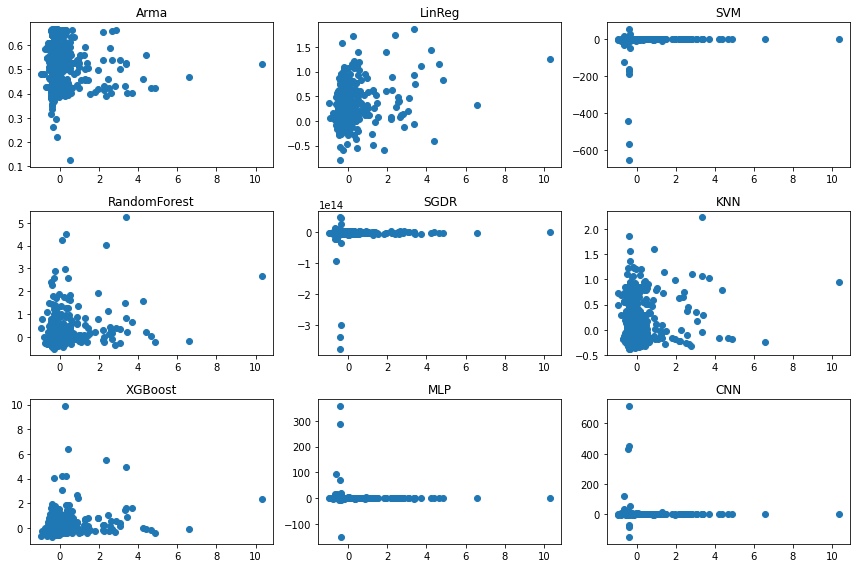

In [249]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
axs[0, 0].scatter(y_test, arima_preds)
axs[0,0].title.set_text('Arma')

axs[0, 1].scatter(y_test, y_test_pred_lin)
axs[0,1].title.set_text('LinReg')

axs[0, 2].scatter(y_test, y_test_pred_svm)
axs[0,2].title.set_text('SVM')

axs[1, 0].scatter(y_test, y_test_pred_rf)
axs[1,0].title.set_text('RandomForest')

axs[1, 1].scatter(y_test, y_test_pred_sgdr)
axs[1,1].title.set_text('SGDR')

axs[1, 2].scatter(y_test, knn_y_pred)
axs[1,2].title.set_text('KNN')

axs[2, 0].scatter(y_test, xgb_preds)
axs[2,0].title.set_text('XGBoost')

axs[2, 1].scatter(y_test, mlp_valid_pred)
axs[2,1].title.set_text('MLP')

axs[2, 2].scatter(y_test, cnn_valid_pred)
axs[2,2].title.set_text('CNN')

fig.tight_layout()
fig.savefig('scatter-resids.png')

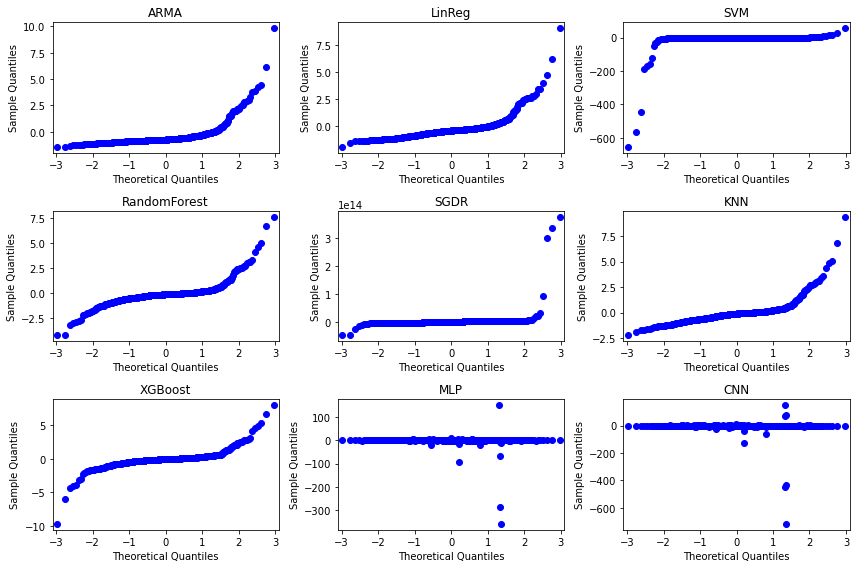

In [250]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
arima_resids = np.array([y_test[i]-arima_preds[i] for i in range(len(arima_preds))])
qqplot(arima_resids, ax=axs[0,0])
axs[0,0].title.set_text('ARMA')

lin_resids = np.array([y_test[i]-y_test_pred_lin[i] for i in range(len(y_test_pred_lin))])
qqplot(lin_resids, ax=axs[0,1])
axs[0,1].title.set_text('LinReg')

svm_resids = np.array([y_test[i]-y_test_pred_svm[i] for i in range(len(y_test_pred_svm))])
qqplot(y_test_pred_svm, ax=axs[0,2])
axs[0,2].title.set_text('SVM')

rf_resids = np.array([y_test[i]-y_test_pred_rf[i] for i in range(len(y_test_pred_rf))])
qqplot(rf_resids, ax=axs[1,0])
axs[1,0].title.set_text('RandomForest')

sgdr_resids = np.array([y_test[i]-y_test_pred_sgdr[i] for i in range(len(y_test_pred_sgdr))])
qqplot(sgdr_resids, ax=axs[1,1])
axs[1,1].title.set_text('SGDR')

knn_resids = np.array([y_test[i]-knn_y_pred[i] for i in range(len(knn_y_pred))])
qqplot(knn_resids, ax=axs[1,2])
axs[1,2].title.set_text('KNN')

xgb_resids = np.array([y_test[i]-xgb_preds[i] for i in range(len(xgb_preds))])
qqplot(xgb_resids, ax=axs[2,0])
axs[2,0].title.set_text('XGBoost')

mlp_resids = np.array([y_test[i]-mlp_valid_pred[i] for i in range(len(mlp_valid_pred))])
qqplot(mlp_resids, ax=axs[2,1])
axs[2,1].title.set_text('MLP')

cnn_resids = np.array([y_test[i]-cnn_valid_pred[i] for i in range(len(cnn_valid_pred))])
qqplot(cnn_resids, ax=axs[2,2])
axs[2,2].title.set_text('CNN')

fig.tight_layout()
fig.savefig('gg-resids.png')